<a href="https://colab.research.google.com/github/MittalNeha/retinopathy-kaggle/blob/master/EfficientNet_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import (Activation, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,
                          Dense, BatchNormalization, GlobalAveragePooling2D)
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.losses import binary_crossentropy, categorical_crossentropy

from keras.applications.resnet50 import ResNet50
# from keras.applications.res

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from keras import metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils import class_weight, shuffle
import cv2
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [0]:
def get_kaggle_data():
  os.environ['KAGGLE_USERNAME'] = "mittalneha"
  os.environ['KAGGLE_KEY'] = "59ec3f992f5fb4b510bebd8dea889381"
  
#   !kaggle competitions download -c aptos2019-blindness-detection
  
#   !mkdir kaggle-data
#   !mv sample_submission.csv kaggle-data/
#   !mv test.csv kaggle-data/

#   !unzip test_images.zip -d kaggle-data/test_images

  !cp /content/gdrive/My\ Drive/Retinopathy/data/aug_train_images.zip .
  !cp /content/gdrive/My\ Drive/Retinopathy/data/aug_train.csv .
  
  !unzip aug_train_images.zip
  !mv aug_train_images kaggle-data/
  !mv aug_train.csv kaggle-data/
  
  !kaggle datasets download -d ratthachat/efficientnet-keras-weights-b0b5
  !cp /content/gdrive/My\ Drive/Retinopathy/data/efficientnet-master.zip .
  !unzip efficientnet-keras-weights-b0b5 -d kaggle-data/efficientnets-weights/
  !unzip efficientnet-master.zip
  

In [0]:
data_dir = "kaggle-data"
# get_kaggle_data()

In [0]:
# sys.path.remove('/content/efficientnet-master')

In [0]:
# !pip install efficientnet-master/

In [0]:
import sys
sys.path.append(os.path.abspath('efficientnet-master/'))
import efficientnet.keras as efn 

In [0]:
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 5

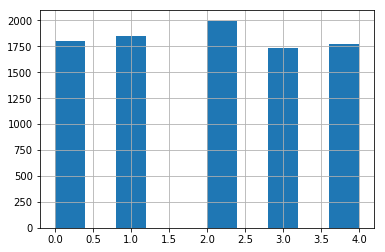

In [33]:
df_train = pd.read_csv('kaggle-data/aug_train.csv')
df_test = pd.read_csv('kaggle-data/test.csv')

df_train.columns = ['id_code', 'diagnosis']

x = df_train['id_code']
y = df_train['diagnosis']

# x, y = shuffle(x, y, random_state=8)
y.hist()


In [34]:
def get_label(diagnosis):
  return [i for i in range(diagnosis + 1)]
#     return ','.join([str(i+1) for i in range(diagnosis + 1)])
df_train['label'] = df_train.diagnosis.apply(get_label)
df_train.head()

,id_code,diagnosis,label
0,000c1434d8d7_0,2,"[0, 1, 2]"
1,001639a390f0,4,"[0, 1, 2, 3, 4]"
2,001639a390f0_0,4,"[0, 1, 2, 3, 4]"
3,001639a390f0_1,4,"[0, 1, 2, 3, 4]"
4,001639a390f0_2,4,"[0, 1, 2, 3, 4]"


In [0]:
mlb = MultiLabelBinarizer(classes=[0,1,2,3,4])
# labels = [(1,2), (1,), (1,2)]

# y = mlb.fit_transform(y)
# mlb.fit_transform(labels)
# mlb.fit_transform(list(y[i]) for i in range(0,len(y)))
# yy = mlb.fit_transform(df_train['diagnosis'])
# mlb.classes_

In [36]:
y = df_train['label']
y = mlb.fit_transform(y)
# y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(7785,)
(7785, 5)
(1374,)
(1374, 5)


In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.5)
],random_order=True)

In [0]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
#             img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
#             img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [0]:
from keras.layers import LeakyReLU

In [0]:
def create_model(input_shape, n_out, model_weights):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB5(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')
#     x = GlobalAveragePooling2D()(base_model.output)
    
    classifier = Sequential()
    classifier.add(GlobalAveragePooling2D())
#     classifier.add(Flatten())   
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(1024))
    classifier.add(BatchNormalization())
    classifier.add(LeakyReLU())
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(n_out, activation='sigmoid', name='final_output'))
    #Use sigmoid for multilabel and softmax for single label classification
#     final_output = Dense(n_out, activation='sigmoid', name='final_output')(classifier.output)
    
    model = Sequential([
    base_model, 
    classifier
])
#     model = Model(input_tensor, final_output)
#     model.load_weights(model_weights)
    
    return model

In [0]:
from keras.callbacks import LambdaCallback
import math

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        
          
        if math.isnan(loss) or loss > self.best_loss *100:
            self.model.stop_training = True
            print("Stop Training {}, best_loss{}, lr{}".format(loss, self.best_loss, lr))
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)
#         print("Current Learning Rate{}".format(lr))

    def find(self, train_gen, start_lr, end_lr, batch_size=64, epochs=1, steps=1):
        num_batches = epochs * steps
#         x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)
        print(self.lr_mult)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

#         self.model.fit(x_train, y_train,
#                         batch_size=batch_size, epochs=epochs,
#                         callbacks=[callback])
#         print("Calling fit")
        self.model.fit_generator(
                  train_gen,
                  steps_per_epoch=steps,
                  
                  epochs=epochs,
                  verbose=1,
                  workers=1, use_multiprocessing=False,
                  callbacks=[callback])
    
#         print("After fit")

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)
        print("Set lr to {}".format(original_lr))

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives
    
    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)
        
    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        print(np.min(derivatives))
        print(np.max(derivatives))
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

244.0
1.0094814913716528
Epoch 1/4
244/244 [==============================] - 346s 1s/step - loss: 0.6964 - acc: 0.6324
Epoch 2/4
244/244 [==============================] - 305s 1s/step - loss: 0.2723 - acc: 0.8891
Epoch 3/4
244/244 [==============================] - 305s 1s/step - loss: 0.2425 - acc: 0.9047
Epoch 4/4
244/244 [==============================] - 305s 1s/step - loss: 0.7211 - acc: 0.7327
Set lr to 0.0010000000474974513


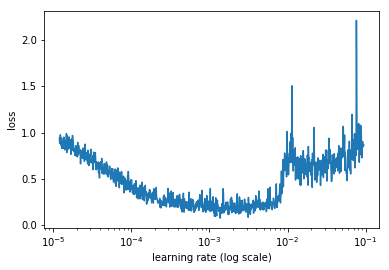

In [42]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/resnet50/Resnet50_bestqwk.h5')
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
lr_finder = LRFinder(model)

def determineLearningRate():    
    batch_size = 32
    num_classes = NUM_CLASSES
    epochs = 4
    
    train_generator = My_Generator(train_x, train_y, batch_size, is_train=True)
    steps = np.ceil(float(len(train_x)) / float(batch_size))
    print(steps)
    lr_finder.find(train_generator, start_lr=0.00001, end_lr=0.1, batch_size=batch_size, epochs=epochs, steps=steps)
    lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
    plt.show()
    return model
determineLearningRate()

In [72]:
len(lr_finder.lrs)

976

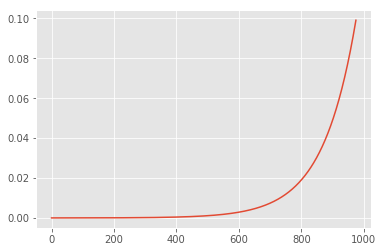

In [66]:
plt.plot(lr_finder.lrs)

In [82]:
lr_finder.lrs[280]

0.00014045619

In [85]:
for idx, lr in enumerate(lr_finder.lrs):
  if abs(lr-0.0001) <0.000011:
    print('lr:{}, der{}'.format(lr, der[idx]))
  

lr:8.929344767238945e-05, der0.009547555446624756
lr:9.014008537633345e-05, der0.010408300161361694
lr:9.099474846152589e-05, der-0.012284409999847413
lr:9.185751696350053e-05, der0.01598127782344818
lr:9.272846364183351e-05, der0.00686296820640564
lr:9.36076685320586e-05, der0.003251376748085022
lr:9.449521166970953e-05, der0.007986918091773987
lr:9.539116581436247e-05, der0.0013180464506149293
lr:9.629561827750877e-05, der-0.012093159556388854
lr:9.720864181872457e-05, der0.003918248414993286
lr:9.813032374950126e-05, der0.0004709482192993164
lr:9.906074410537258e-05, der-0.004517486691474915
lr:9.99999901978299e-05, der0.0002392113208770752
lr:0.00010094814206240699, der-0.009109675884246826
lr:0.00010190527973463759, der-0.013261240720748902
lr:0.00010287149052601308, der-0.0007106214761734009
lr:0.00010384686902398244, der-0.010985729098320008
lr:0.00010483149526407942, der-0.0028750091791152955
lr:0.0001058254565577954, der0.006919604539871216
lr:0.00010682884021662176, der-0.014

In [67]:
der = lr_finder.get_derivatives(10)
print(np.min(der))
print(np.max(der))

-0.13595679998397828
0.1512671709060669


In [70]:
best_der_idx = np.argmin(der[10:-5])
lr_finder.lrs[2:-5][best_der_idx]

0.077507585

In [0]:
aa = [d for d in der if d < 0]

In [65]:
aa

[-0.05918574333190918,
 -0.14059531688690186,
 -0.004923999309539795,
 -0.03995025157928467,
 -0.048403382301330566,
 -0.10690760612487793,
 -0.07816386222839355,
 -0.029375970363616943,
 -0.01648944616317749,
 -0.0431520938873291,
 -0.052551090717315674,
 -0.037639617919921875,
 -0.07802700996398926,
 -0.11146128177642822,
 -0.07330876588821411,
 -0.016149938106536865,
 -0.05520987510681152,
 -0.024663329124450684,
 -0.058837950229644775,
 -0.03684127330780029,
 -0.20572221279144287,
 -0.06508249044418335,
 -0.07456612586975098,
 -0.0783151388168335,
 -0.0838547945022583,
 -0.07455426454544067,
 -0.1590978503227234,
 -0.11134546995162964,
 -0.16114461421966553,
 -0.07310497760772705,
 -0.0203704833984375,
 -0.026395440101623535,
 -0.07299035787582397,
 -0.11189717054367065,
 -0.04080629348754883,
 -0.08377575874328613,
 -0.07677978277206421,
 -0.057830095291137695,
 -0.07039833068847656,
 -0.03612351417541504,
 -0.039302051067352295,
 -0.11505669355392456,
 -0.05015885829925537,
 -0.0

In [61]:
print(np.min(dd))
print(np.max(dd))

0
0


In [68]:
lr_finder.get_best_lr(sma=10)

-0.13595679998397828
0.1512671709060669


0.07605845

In [0]:
!mkdir 'kaggle-data/model'

In [0]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 15; batch_size = 16
checkpoint = ModelCheckpoint('kaggle-data/model/EffNetB5-{epoch:02d}-{val_acc:.4f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# checkpoint = ModelCheckpoint('kaggle-data/model/xception-model.h5', verbose=1, monitor='val_acc',
#                               save_best_only=True, save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

csv_logger = CSVLogger(filename='kaggle-data/model/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=True, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')

In [0]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [0]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            
            def get_pred(y):
#                 print(y[0])
                y_pred = y > 0.5
#                 print(y_pred[0])
                y_pred = y_pred.astype(int).sum(axis=1) - 1
#                 print(y_pred.reshape(-1))
                return y_pred.reshape(-1)
                
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(get_pred(self.y_val),
                                      get_pred(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('kaggle-data/model/EffNet_qwk-{0:02d}-{1:.4f}.h5'.format(epoch, score))

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [0]:
train_y.shape

(7785, 5)

In [47]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy',
#              loss=kappa_loss,
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])
#, metrics=['accuracy']
history = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/15
487/487 [==============================] - 405s 832ms/step - loss: 0.4513 - acc: 0.5946 - val_loss: 0.2480 - val_acc: 0.8972

Epoch 00001: val_loss improved from inf to 0.24802, saving model to kaggle-data/model/EffNetB5-01-0.8972.h5
86/86 [==============================] - 25s 288ms/step

 epoch: 1 - QWK_score: 0.789239 

saving checkpoint:  0.7892385827873287
Epoch 2/15
487/487 [==============================] - 345s 709ms/step - loss: 0.3341 - acc: 0.6466 - val_loss: 0.1881 - val_acc: 0.9237

Epoch 00002: val_loss improved from 0.24802 to 0.18809, saving model to kaggle-data/model/EffNetB5-02-0.9237.h5
86/86 [==============================] - 14s 160ms/step

 epoch: 2 - QWK_score: 0.860759 

saving checkpoint:  0.8607587939698492
Epoch 3/15
487/487 [==============================] - 345s 708ms/step - loss: 0.3017 - acc: 0.6529 - val_loss: 0.1812 - val_acc: 0.9319

Epoch 00003: val_loss improved from 0.18809 to 0.18119, saving model to kaggle-data/model/EffNetB5-03-0.9319.

In [0]:
lr = K.get_value(model.optimizer.lr)
# K.set_value(model.optimizer.lr, lr/2)

In [49]:
lr

1e-04

In [0]:
K.get_value(model.optimizer.lr)

0.00025

In [94]:
epochs = 30
history2 = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    initial_epoch=15,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 16/30
487/487 [==============================] - 344s 706ms/step - loss: 0.1732 - acc: 0.6941 - val_loss: 0.0670 - val_acc: 0.9817

Epoch 00016: val_loss improved from 0.07786 to 0.06696, saving model to kaggle-data/model/EffNetB5-16-0.9817.h5
86/86 [==============================] - 14s 159ms/step

 epoch: 16 - QWK_score: 0.970888 

saving checkpoint:  0.9708877903764442
Epoch 17/30
487/487 [==============================] - 344s 706ms/step - loss: 0.1692 - acc: 0.6910 - val_loss: 0.0615 - val_acc: 0.9825

Epoch 00017: val_loss improved from 0.06696 to 0.06151, saving model to kaggle-data/model/EffNetB5-17-0.9825.h5
86/86 [==============================] - 14s 159ms/step

 epoch: 17 - QWK_score: 0.972795 

saving checkpoint:  0.9727947436777666
Epoch 18/30
487/487 [==============================] - 344s 706ms/step - loss: 0.1717 - acc: 0.6987 - val_loss: 0.0675 - val_acc: 0.9808

Epoch 00018: val_loss did not improve from 0.06151
86/86 [==============================] - 14s 160m

Load the best model

In [0]:
model.load_

# Evaluate Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
all_scores = []
for i, name in tqdm(enumerate(valid_x)):
  path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
  image = cv2.imread(path)
  image = cv2.resize(image, (SIZE, SIZE))

  scores = model.evaluate((image[np.newaxis])/255, np.reshape(valid_y[i], (1,5)), verbose=0)
  all_scores.append(scores)

mean = np.mean(all_scores, axis=0)
sd = np.std(all_scores, axis=0)
print("Loss:    %.2f%% (+/- %.2f%%)" % (mean[0], sd[0]))
print("Accuracy:%.2f%% (+/- %.2f%%)" % (mean[1], sd[1]))

1374it [01:07, 20.22it/s]

Loss:    3.80% (+/- 3.01%)
Accuracy:1.00% (+/- 0.00%)


In [0]:
history2.history


NameError: ignored

In [0]:
def get_pred(y):
  y_pred = y > 0.5
  y_pred = y_pred.astype(int).sum(axis=1) - 1
  return y_pred.reshape(-1)

def check_model(hist, model):
  
  #Plot the curves
  N = len(hist.history['loss'])

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
  
 
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["acc"], label="train_acc")
  plt.plot(np.arange(0, N), hist.history["val_acc"], label="val_acc")
  plt.title("Training Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), qwk.history, label="kappa_score")
  plt.title("Kappa score on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("kappa")
  plt.legend(loc="lower left")
  
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["lr"], label="learning_rate")
 
  plt.title("Learning Rate on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("LR")
  plt.legend(loc="lower left")
  
  
  #confusion matrix
  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

1374it [00:50, 27.75it/s]


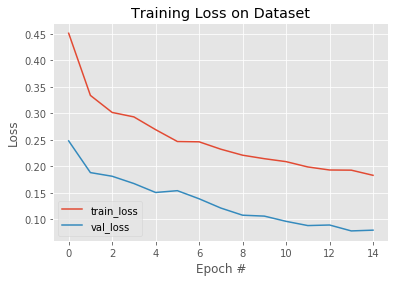

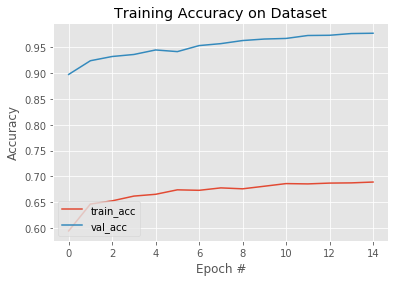

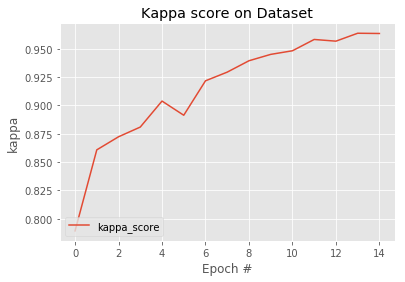

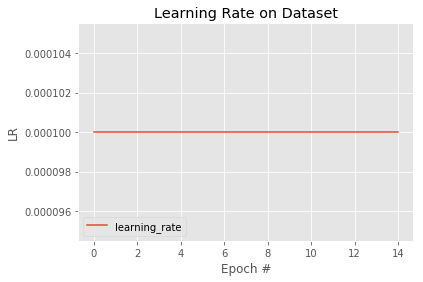

<Figure size 432x288 with 0 Axes>

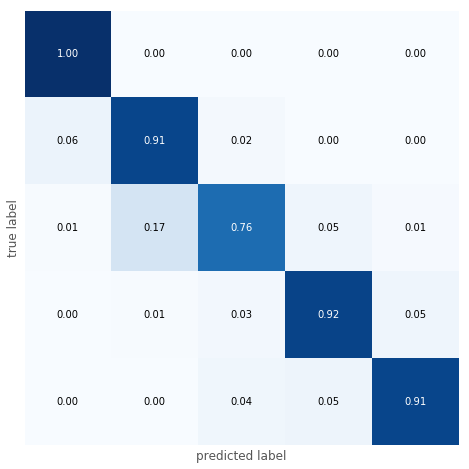

In [51]:
check_model(history, model)

In [0]:
  def get_pred(y):
    y_pred = y > 0.5
    mask = y_pred == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

In [0]:
qwk.history

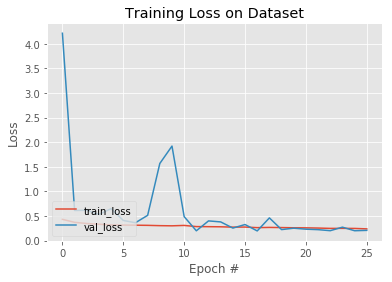

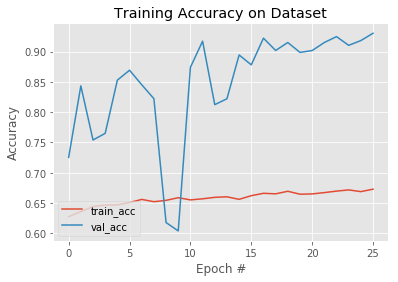

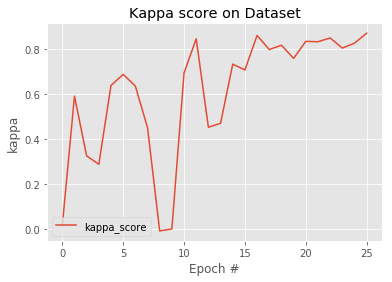

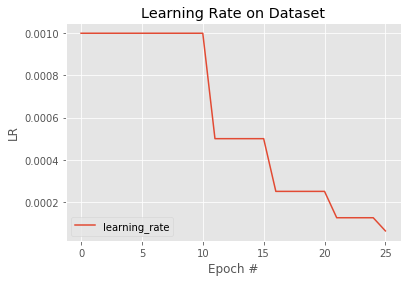

In [0]:
check_model(history, model)

1374it [01:07, 20.37it/s]


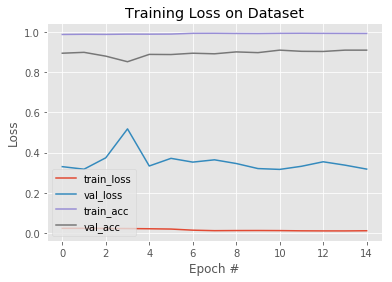

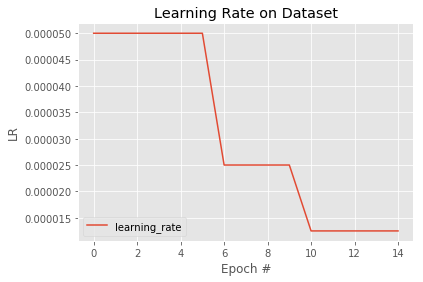

<Figure size 432x288 with 0 Axes>

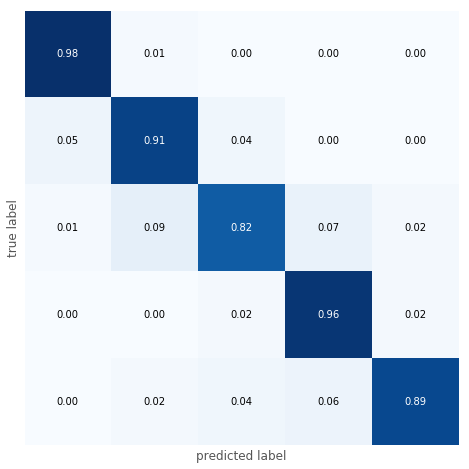

In [0]:
check_model(history2, model)

# Save Model

In [95]:
%cd kaggle-data/model

/content/kaggle-data/model


In [0]:
!rm EffNet_multi_lrelu2.zip

In [96]:
!zip EffNet_multi_lrelu3.zip EffNet_qwk-27-0.9820.h5
!cp EffNet_multi_lrelu3.zip /content/gdrive/My\ Drive/Retinopathy/models/EffNet/

  adding: EffNet_qwk-27-0.9820.h5 (deflated 8%)


In [0]:
!cp EffNet_multi_lrelu2.zip /content/gdrive/My\ Drive

In [91]:
!ls /content/gdrive/My\ Drive/Retinopathy/models/EffNet -l

total 772719
-rw------- 1 root root 340474381 Aug 20 04:41 EffNet_multi_456.zip
-rw------- 1 root root 113887759 Aug 20 08:53 EffNet_multi_lrelu2.zip
-rw------- 1 root root 336900255 Aug 20 04:42 EffNet_multi_lrelu.zip


In [93]:
%cd ../../

/content


# Compare models

In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug3.zip .
!mkdir resnet50_aug3
!unzip resnet50_aug3.zip -d resnet50_aug3

Archive:  resnet50_aug3.zip
  inflating: resnet50_aug3/Resnet50-09-0.8952.h5  
  inflating: resnet50_aug3/Resnet50_qwk-23-0.9533.h5  


In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug4.zip .
!mkdir resnet50_aug4
!unzip resnet50_aug4.zip -d resnet50_aug4

Archive:  resnet50_aug4.zip
  inflating: resnet50_aug4/Resnet50_qwk-29-0.9558.h5  


In [0]:
def preprocess_image(img):
  
  if img.shape[2] ==1:
    img = np.dstack([img, img, img])

  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret, img2 = cv2.threshold(img1, 10, 255, cv2.THRESH_BINARY)
  points = np.argwhere(img2!=0)
  points = np.fliplr(points)
  x, y, w, h = cv2.boundingRect(points)

  color_cropped = img[y:y+h, x:x+w]

  clahe = cv2.createCLAHE(clipLimit=4.0)

  lab = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab_planes[1] = clahe.apply(lab_planes[1])
  lab_planes[2] = clahe.apply(lab_planes[2])
  
  out = cv2.merge(lab_planes)
  img3 = cv2.cvtColor(out, cv2.COLOR_LAB2BGR)
  
  img = cv2.resize(img3, (SIZE,SIZE), cv2.INTER_AREA)
  
#   img = img.astype(np.float32)/255
  
  return img

In [0]:
train, val = train_test_split(df_train, test_size=0.4)
train_data = train

In [0]:
train.head()

,id_code,diagnosis
7906,d9e58e4d8689,0
5884,a2ddabee14e9,4
191,05a5183c92d0_0,1
7120,c3cd0200df79_1,3
7202,c613db1cab27,2


In [0]:
model1 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights="resnet50_aug3/Resnet50-09-0.8952.h5")
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

model2 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='resnet50_aug4/Resnet50_qwk-29-0.9558.h5')
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

W0807 06:26:48.074534 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 06:26:48.142511 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 06:26:48.170713 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0807 06:26:48.221229 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 06:26:48.222414

In [0]:
#Evaluate with train data itself
train_img = []
train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    train_img.append(img)
    train_labels.append(label)
    
train_img = np.array(train_img)
train_labels = np.array(train_labels)

## Evaluate First Model

In [0]:
eval_loss1, eval_score1 = model1.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss1)
print("Accuracy on test set: ", eval_score1)

5495/5495 [==============================] - 96s 18ms/step
Loss on test set:  7.650551852624561
Accuracy on test set:  0.2043676069316482


In [0]:
#Evaluate with train data itself
predicted1 = []
# train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    score_predict = model1.predict((img[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    predicted1.append(str(label_predict))
    

In [0]:
cm  = confusion_matrix(orig_train_labels, predicted1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

ValueError: ignored

In [0]:
preds1 = model1.predict(train_img, batch_size=16)
preds1 = np.argmax(preds1, axis=-1)

# Original labels
orig_train_labels = np.argmax(train_labels, axis=-1)

## Confusion Matrix

<Figure size 432x288 with 0 Axes>

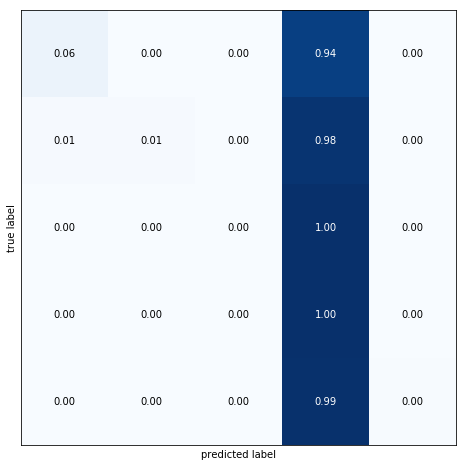

In [0]:
cm  = confusion_matrix(orig_train_labels, preds1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

## Evaluate second Model

In [0]:
eval_loss2, eval_score2 = model2.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss2)
print("Accuracy on test set: ", eval_score2)

5495/5495 [==============================] - 91s 17ms/step
Loss on test set:  7.940974250460235
Accuracy on test set:  0.26223839856040165


In [0]:
preds2 = model2.predict(train_img, batch_size=16)
preds2 = np.argmax(preds2, axis=-1)

# Original labels
# orig_train_labels = np.argmax(train_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

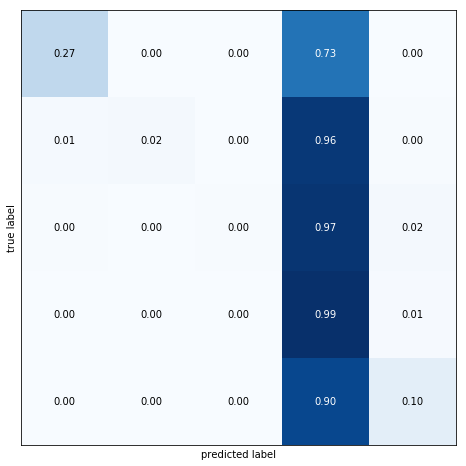

In [0]:
cm  = confusion_matrix(orig_train_labels, preds2)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()